# Tight Bounds for Binomial

In [32]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import cvxpy as cp
import confirm.mini_imprint.bound.binomial as binomial

This notebook studies the behavior of a collection of bounds in a simple binomial test setting.
Consider $X \sim Binom(n, p(\theta))$ where $n$ is fixed, $\theta \in \mathbb{R}$ is the natural parameter,
and $p(\theta)$ is the sigmoid function.
For a fixed critical threshold $t^*$, we reject if $X > t^*$.

\begin{align*}
A(\theta) &:= n\log(1 + e^{\theta})\\
A(\theta_0 + qv) - A(\theta_0)
&:=
n\left(\log(1 + e^{\theta_0+qv}) - \log(1 + e^{\theta_0})\right)
\\&\leq
n q|v|
\end{align*}

## Taylor Bound

In [28]:
def f(theta, n, t):
    return scipy.stats.binom.sf(t, n, scipy.special.expit(theta))
    
def df(theta, n, t):
    p = scipy.special.expit(theta)
    return scipy.stats.binom.expect(
        lambda x: (x > t) * (x - n*p),
        args=(n, p),
    )

In [29]:
def taylor_bound(f0, df0, vs, theta_0, n):
    p = scipy.special.expit(theta_0)
    return f0 + df0 * vs + 0.5 * vs**2 * n * p * (1-p)

## Centered Holder Bound

In [30]:
def copt(a, p):
    return 1 / (1 + ((1-a)/a)**(1/(p-1)))

def C_numerical(n_arm_samples, t, hp, hq):
    p = scipy.special.expit(t)
    xs = np.arange(n_arm_samples + 1).astype(np.float64)
    eggq = np.abs(xs - n_arm_samples * p[:, None]) ** hq
    return np.sum(eggq * scipy.stats.binom.pmf(xs, n_arm_samples, p[:, None]), axis=-1) ** (1 / hq)
    
def holder_bound(f0, n_arm_samples, theta_0, vs, hp, hc='opt'):
    if isinstance(hp, np.ndarray):
        bounds = np.array([holder_bound(f0, n_arm_samples, theta_0, vs, hpi, hc) for hpi in hp])
        return np.min(bounds, axis=0)
    if hc == 'opt':
        hc = copt(f0, hp)
    hq = 1 / (1 - 1 / hp)
    B = hc ** hp
    A = (1 - hc) ** hp - B
    Cs = [
        scipy.integrate.quadrature(
            lambda h: np.abs(v) * C_numerical(n_arm_samples, theta_0 + h * v, hp, hq),
            0.0,
            1.0,
        )[0]
        for v in vs
    ]
    Cs = np.maximum.accumulate(Cs)
    return 1/A * (A*Cs / hq + (A*f0 + B)**(1/hq))**hq - B/A

## Exponential Holder Improved

In [31]:
def log_partition(t, n):
    return n * jnp.log(1 + jnp.exp(t))

def log_partition_cp(t, n):
    return n * cp.logistic(t)

In [33]:
def exp_holder_impr_bound_(f0, n, theta_0, vs, q):
    A0 = log_partition(theta_0, n)
    bounds = f0 * np.exp(
        (log_partition(theta_0 + q * vs, n) - A0) / q
        - np.log(f0) / q
        - (log_partition(theta_0 + vs, n) - A0)
    )
    return bounds

def exp_holder_impr_bound(f0, n, theta_0, vs, q = 'inf'):
    if isinstance(q, np.ndarray):
        bounds = np.array([exp_holder_impr_bound_(f0, n, theta_0, vs, qi)[1] for qi in q])
        order = np.argmin(bounds, axis=0)
        return q[order], bounds[order, np.arange(0, len(order))]
    if q == 'inf' or (isinstance(q, float) and np.isinf(q)): 
        return None, f0 * np.exp(n*vs - log_partition(theta_0 + vs, n) + log_partition(theta_0, n))
    if q == 'opt':
        a = -np.log(f0)
        solver = binomial.ForwardQCPSolver(n)
        q_solver = jax.jit(jax.vmap(solver.solve, in_axes=(None, 0, None)))
        qs = q_solver(theta_0, vs, a)
        bounds = exp_holder_impr_bound_(f0, n, theta_0, vs, qs)
        return qs, bounds
    return None, bounds

## Performance Comparison

In [83]:
n = 350
theta_0 = -1.0
theta_boundary = 0
v_max = theta_boundary - theta_0
n_steps = 100
alpha = 0.025
p_boundary = scipy.special.expit(theta_boundary)
thresh = np.sqrt(n*p_boundary*(1-p_boundary)) * scipy.stats.norm.isf(alpha) + n*p_boundary

In [84]:
f0 = f(theta_0, n, thresh)
df0 = df(theta_0, n, thresh)
vs = np.linspace(0.001, v_max, n_steps)

In [85]:
def run(theta_0, n, f0, df0, vs, thresh, hp, hc, q='inf'):
    # compute true Type I Error
    thetas = theta_0 + vs
    fs = f(thetas, n, thresh)

    # compute taylor bound
    taylor_bounds = taylor_bound(f0, df0, vs, theta_0, n)

    # compute holder centered bound
    holder_bounds = [holder_bound(f0, n, theta_0, vs, hp, c) for c in hc]
    
    # compute exp holder impr bound
    qs, exp_holder_impr_bounds = exp_holder_impr_bound(f0, n, theta_0, vs, q)

    # plot everything
    plt.plot(thetas, fs, ls='--', color='black', label='True TIE')
    plt.plot(thetas, taylor_bounds, ls='-', label='taylor')
    for i, c in enumerate(hc):
        plt.plot(thetas, holder_bounds[i], ls='--', label=f'centered-holder({c}), p={hp}')
    plt.plot(thetas, exp_holder_impr_bounds, ls=':', label='exp-holder-impr')
    plt.ylim(np.min(fs)-1e-4, np.max(exp_holder_impr_bounds)+1e-4)
    plt.legend()
    plt.show()
    
    return qs

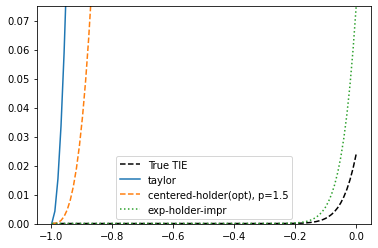

In [86]:
qs = run(
    theta_0=theta_0,
    n=n,
    f0=f0,
    df0=df0,
    vs=vs,
    thresh=thresh,
    hp=1.5,
    hc=['opt'],
    q='opt',
)